<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/Chromatin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential downloads

In [1]:
!wget -q -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1KriedE029fLEmQP3Jy_b6H-j0eRa_Icj&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip -q downloaded_file.zip

In [2]:

!pip -q install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip -q install openpyxl


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.3 MB/s

In [3]:

import os
import glob
import imageio.v2 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import torch.nn.functional as F
from funlib.learn.torch.models import Vgg3D

# Data Analyze

## Size

In [4]:
import os
import glob
from PIL import Image
from collections import defaultdict

def analyze_raw_images(root_dir):
    cell_type_sizes = defaultdict(list)
    all_widths = []
    all_heights = []
    min_width = float('inf')
    max_width = float('-inf')
    min_height = float('inf')
    max_height = float('-inf')

    # Iterate through each cell type directory
    for cell_type in sorted(os.listdir(root_dir)):
        cell_type_dir = os.path.join(root_dir, cell_type)

        if os.path.isdir(cell_type_dir):
            # Iterate through each sample directory
            sample_dirs = sorted(os.listdir(cell_type_dir))
            for sample in sample_dirs:
                raw_dir = os.path.join(cell_type_dir, sample, 'raw')

                # Get all .tif files in the raw directory
                raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))

                # Process each raw image
                for raw_file in raw_files:
                    with Image.open(raw_file) as img:
                        width, height = img.size

                        # Collect sizes by cell type
                        cell_type_sizes[cell_type].append((width, height))

                        # Update global min and max dimensions
                        all_widths.append(width)
                        all_heights.append(height)
                        min_width = min(min_width, width)
                        max_width = max(max_width, width)
                        min_height = min(min_height, height)
                        max_height = max(max_height, height)

    # Calculate average width and height across all images
    avg_width = sum(all_widths) / len(all_widths) if all_widths else 0
    avg_height = sum(all_heights) / len(all_heights) if all_heights else 0

    # Calculate unique sizes per cell type
    unique_sizes_by_cell_type = {cell_type: set(cell_type_sizes[cell_type]) for cell_type in cell_type_sizes}

    return avg_width, avg_height, min_width, max_width, min_height, max_height, unique_sizes_by_cell_type

# Specify the path to your dataset
root_dir = '/content/chromatin_task'  # Replace with your dataset path

# Analyze raw image sizes
avg_width, avg_height, min_width, max_width, min_height, max_height, unique_sizes_by_cell_type = analyze_raw_images(root_dir)

print(f"Average Resolution of Raw Images - Width: {avg_width}, Height: {avg_height}")
print(f"Min Width: {min_width}, Max Width: {max_width}")
print(f"Min Height: {min_height}, Max Height: {max_height}")
print("\nUnique Sizes by Cell Type:")
for cell_type, sizes in unique_sizes_by_cell_type.items():
    print(f"{cell_type}: {sizes}")


Average Resolution of Raw Images - Width: 72.38105165624276, Height: 73.55306926106093
Min Width: 23, Max Width: 119
Min Height: 34, Max Height: 116

Unique Sizes by Cell Type:
Glia: {(95, 68)}
L-shaped: {(72, 73), (59, 55), (64, 69), (55, 66), (62, 72), (67, 68), (62, 81), (70, 64), (55, 75), (65, 52), (76, 52), (59, 82), (79, 60), (82, 56), (76, 70), (71, 56), (66, 69), (76, 79), (63, 61), (68, 84), (80, 67), (55, 77), (56, 76), (85, 57), (85, 66), (75, 65), (65, 72), (76, 72), (73, 67), (69, 60), (70, 59), (70, 68), (54, 81), (66, 64), (58, 81), (95, 54), (72, 70), (68, 72), (66, 84), (54, 67), (71, 83), (64, 77), (54, 76), (56, 73), (76, 51), (75, 71), (66, 68), (81, 50), (70, 84), (50, 81), (75, 80), (66, 77), (62, 64), (65, 81), (71, 85), (77, 64), (62, 91), (75, 55), (69, 78), (61, 74), (79, 55), (60, 84), (66, 70), (61, 83), (79, 64), (81, 61), (73, 57), (79, 73), (54, 53), (62, 75), (63, 74), (58, 62), (67, 74), (80, 71), (75, 57), (62, 59), (65, 76), (71, 71), (73, 68), (77, 

# VGG no mask

In [ ]:
!cp /content/drive/MyDrive/fine_tuned_vgg3d.pth /content

In [ ]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors
        raw_data = torch.tensor(raw_data, dtype=torch.float32)
        mask_data = torch.tensor(mask_data, dtype=torch.float32)

        # Get the integer index for the cell_type
        target = self.cell_type_to_idx[cell_type]

        sample_data = {'cell_type': cell_type, 'sample': sample, 'raw': raw_data, 'mask': mask_data, 'target': target}

        if self.transform:
            sample_data['raw'] = self.transform(sample_data['raw'])
            sample_data['mask'] = self.transform(sample_data['mask'])

        return sample_data
import os
import torch

def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        # Paths and directories
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()

    # The checkpoint contains the full model's state_dict, so we update the model's state_dict
    # If the checkpoint doesn't have a classifier key, load the model directly.
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        # If no 'model_state_dict', assume the checkpoint contains all weights
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    # Return the model with the loaded weights
    model.eval()
    return model


# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(size=(75, 75, 75), scale=(0.8, 1.2)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0))  # Adds a channel dimension
])

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x
        x = x.view(x.size(0), -1)
        return self.classifier(x)


transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)

# dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=transform)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

output_classes = len(dataset.cell_types)

# Initialize the model
output_classes = len(dataset.cell_types)
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=output_classes, input_fmaps=1)

# Paths and directories
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

# Define checkpoint path
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# # Check if the checkpoint exists
# if os.path.exists(checkpoint_path):
#     print("Checkpoint found, resuming training...")
#     model = load_model_from_checkpoint(model, fine_tuned_path)
# else:
#     print("No checkpoint found, starting from scratch.")

model.to(device)  # Move model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with CUDA
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
from tqdm import tqdm
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, batch in (enumerate(train_dataloader)):
        inputs, targets = batch['raw'].to(device), batch['target'].to(device)  # Move inputs and targets to GPU

        # Ensure inputs are of shape [batch_size, 1, depth, height, width]
        inputs = inputs.squeeze(2)  # Remove extra dimension at index 2 (if present)

        targets = torch.tensor(targets, dtype=torch.long).to(device)  # Ensure the targets are long integers for cross-entropy

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Test phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inputs, targets = batch['raw'].to(device), batch['target'].to(device)

            inputs = inputs.squeeze(2)

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_losses.append(running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting loss and accuracy using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_losses, mode='lines', name='Test Loss'))
fig_loss.update_layout(title="Loss over Epochs", xaxis_title="Epoch", yaxis_title="Loss")

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, mode='lines', name='Test Accuracy'))
fig_acc.update_layout(title="Accuracy over Epochs", xaxis_title="Epoch", yaxis_title="Accuracy (%)")

fig_loss.show()
fig_acc.show()
# Evaluation on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['raw'].to(device), batch['target'].to(device)
        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_vgg3d.pth")


VGG3D checkpoint already exists.
Loading model from fine_tuned_vgg3d.pth...


<ipython-input-2-6715e4964020>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-2-6715e4964020

Epoch [1/30] Train Loss: 2.3133, Train Accuracy: 33.13% | Test Loss: 2.5097, Test Accuracy: 20.33%
Epoch [2/30] Train Loss: 1.8245, Train Accuracy: 45.60% | Test Loss: 1.8523, Test Accuracy: 33.33%
Epoch [3/30] Train Loss: 1.6187, Train Accuracy: 47.03% | Test Loss: 1.7777, Test Accuracy: 39.84%
Epoch [4/30] Train Loss: 1.4858, Train Accuracy: 47.44% | Test Loss: 1.8598, Test Accuracy: 30.89%
Epoch [5/30] Train Loss: 1.4666, Train Accuracy: 51.12% | Test Loss: 1.5743, Test Accuracy: 47.97%
Epoch [6/30] Train Loss: 1.4252, Train Accuracy: 49.08% | Test Loss: 1.6842, Test Accuracy: 45.53%
Epoch [7/30] Train Loss: 1.3606, Train Accuracy: 52.97% | Test Loss: 2.1418, Test Accuracy: 29.27%
Epoch [8/30] Train Loss: 1.3439, Train Accuracy: 57.06% | Test Loss: 1.6154, Test Accuracy: 49.59%
Epoch [9/30] Train Loss: 1.3992, Train Accuracy: 53.37% | Test Loss: 1.7601, Test Accuracy: 43.09%
Epoch [10/30] Train Loss: 1.2939, Train Accuracy: 53.99% | Test Loss: 1.7471, Test Accuracy: 41.46%
Epoch [11

<ipython-input-2-6715e4964020>:135: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-2-6715e4964020>:354: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test Accuracy: 0.5203
Classification Report:
                           precision    recall  f1-score   support

                     Glia       0.00      0.00      0.00         0
                 L-shaped       0.60      0.78      0.68        23
        Line detector OGL       0.55      0.55      0.55        11
       Medium first order       0.27      0.67      0.38         6
Medulla projecting MP IGL       0.00      0.00      0.00         1
   Medulla projecting OGL       0.00      0.00      0.00         1
           Tangential IGL       1.00      0.25      0.40         4
            Three-pronged       0.00      0.00      0.00         5
                 U-shaped       0.00      0.00      0.00         4
 Unipolar plex-porjecting       0.43      0.43      0.43         7
              centrifugal       0.29      0.67      0.40         3
        large first order       0.67      0.50      0.57         4
           large palisade       0.00      0.00      0.00         0
           multi

In [ ]:
!cp /content/fine_tuned_vgg3d.pth /content/drive/MyDrive

# with mask loss functions

VGG3D checkpoint already exists.
fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-1-593f3c9b38fa>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-1-593f3c9b38fa

RuntimeError: The size of tensor a (32) must match the size of tensor b (75) at non-singleton dimension 1

In [ ]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

import os
import torch

def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        # Paths and directories
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()

    # The checkpoint contains the full model's state_dict, so we update the model's state_dict
    # If the checkpoint doesn't have a classifier key, load the model directly.
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        # If no 'model_state_dict', assume the checkpoint contains all weights
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    # Return the model with the loaded weights
    model.eval()
    return model


# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(size=(75, 75, 75), scale=(0.8, 1.2)),
    # transforms.ToTensor(),  # Converts the PIL Image or NumPy array to a torch tensor
])

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x
        x = x.view(x.size(0), -1)
        return self.classifier(x)


transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)

# dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=transform)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

output_classes = len(dataset.cell_types)

# Initialize the model
output_classes = len(dataset.cell_types)
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=output_classes, input_fmaps=1)

# Paths and directories
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

# Define checkpoint path
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# # Check if the checkpoint exists
# if os.path.exists(checkpoint_path):
#     print("Checkpoint found, resuming training...")
#     model = load_model_from_checkpoint(model, fine_tuned_path)
# else:
#     print("No checkpoint found, starting from scratch.")

model.to(device)  # Move model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with CUDA
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
from tqdm import tqdm
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    def rgb_to_grayscale(tensor):
        # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
        r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
        grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return grayscale.unsqueeze(1)  # Add channel dimension

    # Modify the training loop
    for batch_idx, batch in enumerate(train_dataloader):
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)

        # Convert RGB to grayscale
        inputs = rgb_to_grayscale(inputs)

        # Ensure inputs are of shape [batch_size, 1, depth, height, width]
        inputs = inputs.squeeze(2)  # Remove extra dimension at index 2 (if present)

        targets = torch.tensor(targets, dtype=torch.long).to(device)  # Ensure the targets are long integers for cross-entropy

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Test phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_losses.append(running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting loss and accuracy using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_losses, mode='lines', name='Test Loss'))
fig_loss.update_layout(title="Loss over Epochs", xaxis_title="Epoch", yaxis_title="Loss")

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, mode='lines', name='Test Accuracy'))
fig_acc.update_layout(title="Accuracy over Epochs", xaxis_title="Epoch", yaxis_title="Accuracy (%)")

fig_loss.show()
fig_acc.show()
# Evaluation on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
        inputs = rgb_to_grayscale(inputs)

        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

torch.save(model.state_dict(), "fine_tuned_vgg3d_with_mask_overlaid.pth")


VGG3D checkpoint already exists.
fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-1-f52aa054fc68>:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-1-f52aa054fc68

Epoch [1/30] Train Loss: 2.9880, Train Accuracy: 22.90% | Test Loss: 2.7204, Test Accuracy: 18.70%
Epoch [2/30] Train Loss: 2.5460, Train Accuracy: 22.90% | Test Loss: 2.4870, Test Accuracy: 26.02%
Epoch [3/30] Train Loss: 2.3802, Train Accuracy: 24.95% | Test Loss: 2.3995, Test Accuracy: 26.02%
Epoch [4/30] Train Loss: 2.3283, Train Accuracy: 27.20% | Test Loss: 2.3361, Test Accuracy: 26.83%
Epoch [5/30] Train Loss: 2.2931, Train Accuracy: 30.67% | Test Loss: 2.3419, Test Accuracy: 26.02%
Epoch [6/30] Train Loss: 2.1863, Train Accuracy: 31.49% | Test Loss: 2.3431, Test Accuracy: 28.46%
Epoch [7/30] Train Loss: 2.0889, Train Accuracy: 37.01% | Test Loss: 2.0906, Test Accuracy: 37.40%
Epoch [8/30] Train Loss: 2.0315, Train Accuracy: 38.45% | Test Loss: 1.9949, Test Accuracy: 39.84%
Epoch [9/30] Train Loss: 1.8294, Train Accuracy: 44.79% | Test Loss: 2.1565, Test Accuracy: 35.77%
Epoch [10/30] Train Loss: 1.7552, Train Accuracy: 45.19% | Test Loss: 1.7404, Test Accuracy: 45.53%
Epoch [11

KeyError: 'raw'

In [ ]:

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
        inputs = rgb_to_grayscale(inputs)

        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

torch.save(model.state_dict(), "fine_tuned_vgg3d_with_mask_overlaid.pth")


<ipython-input-4-21580692216a>:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test Accuracy: 0.5041
Classification Report:
                           precision    recall  f1-score   support

                     Glia       0.00      0.00      0.00         1
                 L-shaped       0.51      1.00      0.67        32
        Line detector OGL       0.57      0.22      0.32        18
       Medium first order       0.67      0.55      0.60        11
Medulla projecting MP IGL       0.00      0.00      0.00         0
   Medulla projecting OGL       0.00      0.00      0.00         0
           Tangential IGL       0.00      0.00      0.00         2
            Three-pronged       0.00      0.00      0.00         2
                 U-shaped       0.00      0.00      0.00         5
 Unipolar plex-porjecting       0.00      0.00      0.00         5
              centrifugal       0.29      0.50      0.36         4
        large first order       1.00      0.33      0.50         3
           large palisade       0.50      0.33      0.40         3
           multi

#transparency 80

In [4]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.8):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

import os
import torch

def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        # Paths and directories
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()

    # The checkpoint contains the full model's state_dict, so we update the model's state_dict
    # If the checkpoint doesn't have a classifier key, load the model directly.
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        # If no 'model_state_dict', assume the checkpoint contains all weights
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    # Return the model with the loaded weights
    model.eval()
    return model


# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(size=(75, 75, 75), scale=(0.8, 1.2)),
    # transforms.ToTensor(),  # Converts the PIL Image or NumPy array to a torch tensor
])

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x
        x = x.view(x.size(0), -1)
        return self.classifier(x)


transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)

# dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=transform)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

output_classes = len(dataset.cell_types)

# Initialize the model
output_classes = len(dataset.cell_types)
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=output_classes, input_fmaps=1)

# Paths and directories
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

# Define checkpoint path
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# # Check if the checkpoint exists
# if os.path.exists(checkpoint_path):
#     print("Checkpoint found, resuming training...")
#     model = load_model_from_checkpoint(model, fine_tuned_path)
# else:
#     print("No checkpoint found, starting from scratch.")

model.to(device)  # Move model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with CUDA
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
from tqdm import tqdm
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    def rgb_to_grayscale(tensor):
        # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
        r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
        grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return grayscale.unsqueeze(1)  # Add channel dimension

    # Modify the training loop
    for batch_idx, batch in enumerate(train_dataloader):
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)

        # Convert RGB to grayscale
        inputs = rgb_to_grayscale(inputs)

        # Ensure inputs are of shape [batch_size, 1, depth, height, width]
        inputs = inputs.squeeze(2)  # Remove extra dimension at index 2 (if present)

        targets = torch.tensor(targets, dtype=torch.long).to(device)  # Ensure the targets are long integers for cross-entropy

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Test phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_losses.append(running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting loss and accuracy using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_losses, mode='lines', name='Test Loss'))
fig_loss.update_layout(title="Loss over Epochs", xaxis_title="Epoch", yaxis_title="Loss")

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, mode='lines', name='Test Accuracy'))
fig_acc.update_layout(title="Accuracy over Epochs", xaxis_title="Epoch", yaxis_title="Accuracy (%)")

fig_loss.show()
fig_acc.show()
# Evaluation on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
        inputs = rgb_to_grayscale(inputs)

        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

torch.save(model.state_dict(), "fine_tuned_vgg3d_with_mask_overlaid.pth")


Downloaded VGG3D checkpoint.
fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-4-a76171ad9d1e>:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-4-a76171ad9d1e

Epoch [1/30] Train Loss: 2.5766, Train Accuracy: 23.93% | Test Loss: 2.4826, Test Accuracy: 28.46%
Epoch [2/30] Train Loss: 2.3507, Train Accuracy: 28.02% | Test Loss: 2.2400, Test Accuracy: 28.46%


KeyboardInterrupt: 

#transparency 80 with less class and gray overlay

In [1]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)
    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use gray with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data
import os
import torch

def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        # Paths and directories
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()

    # The checkpoint contains the full model's state_dict, so we update the model's state_dict
    # If the checkpoint doesn't have a classifier key, load the model directly.
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        # If no 'model_state_dict', assume the checkpoint contains all weights
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    # Return the model with the loaded weights
    model.eval()
    return model


# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(size=(75, 75, 75), scale=(0.8, 1.2)),
    # transforms.ToTensor(),  # Converts the PIL Image or NumPy array to a torch tensor
])

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x
        x = x.view(x.size(0), -1)
        return self.classifier(x)


transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)

# dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=transform)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

output_classes = len(dataset.cell_types)

# Initialize the model
output_classes = len(dataset.cell_types)
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=output_classes, input_fmaps=1)

# Paths and directories
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

# Define checkpoint path
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# # Check if the checkpoint exists
# if os.path.exists(checkpoint_path):
#     print("Checkpoint found, resuming training...")
#     model = load_model_from_checkpoint(model, fine_tuned_path)
# else:
#     print("No checkpoint found, starting from scratch.")

model.to(device)  # Move model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with CUDA
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
from tqdm import tqdm
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    def rgb_to_grayscale(tensor):
        # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
        r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
        grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return grayscale.unsqueeze(1)  # Add channel dimension

    # Modify the training loop
    for batch_idx, batch in enumerate(train_dataloader):
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)

        # Convert RGB to grayscale
        inputs = rgb_to_grayscale(inputs)

        # Ensure inputs are of shape [batch_size, 1, depth, height, width]
        inputs = inputs.squeeze(2)  # Remove extra dimension at index 2 (if present)

        targets = torch.tensor(targets, dtype=torch.long).to(device)  # Ensure the targets are long integers for cross-entropy

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Test phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_losses.append(running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting loss and accuracy using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_losses, mode='lines', name='Test Loss'))
fig_loss.update_layout(title="Loss over Epochs", xaxis_title="Epoch", yaxis_title="Loss")

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, mode='lines', name='Test Accuracy'))
fig_acc.update_layout(title="Accuracy over Epochs", xaxis_title="Epoch", yaxis_title="Accuracy (%)")

fig_loss.show()
fig_acc.show()
# Evaluation on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
        inputs = rgb_to_grayscale(inputs)

        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

torch.save(model.state_dict(), "fine_tuned_vgg3d_with_mask_overlaid.pth")


VGG3D checkpoint already exists.
fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-1-9e519cfac6e3>:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-1-9e519cfac6e3

Epoch [1/30] Train Loss: 2.2562, Train Accuracy: 28.22% | Test Loss: 2.1112, Test Accuracy: 33.06%
Epoch [2/30] Train Loss: 2.0881, Train Accuracy: 37.76% | Test Loss: 2.7841, Test Accuracy: 32.23%
Epoch [3/30] Train Loss: 2.0066, Train Accuracy: 40.25% | Test Loss: 2.0238, Test Accuracy: 42.15%
Epoch [4/30] Train Loss: 1.8850, Train Accuracy: 40.66% | Test Loss: 1.7811, Test Accuracy: 42.98%
Epoch [5/30] Train Loss: 1.9162, Train Accuracy: 39.83% | Test Loss: 1.6168, Test Accuracy: 42.98%
Epoch [6/30] Train Loss: 1.7787, Train Accuracy: 41.49% | Test Loss: 1.6225, Test Accuracy: 45.45%
Epoch [7/30] Train Loss: 1.8463, Train Accuracy: 37.55% | Test Loss: 1.5712, Test Accuracy: 47.11%
Epoch [8/30] Train Loss: 1.7283, Train Accuracy: 43.15% | Test Loss: 1.6124, Test Accuracy: 48.76%
Epoch [9/30] Train Loss: 1.7078, Train Accuracy: 43.78% | Test Loss: 1.6035, Test Accuracy: 45.45%
Epoch [10/30] Train Loss: 1.7177, Train Accuracy: 45.23% | Test Loss: 1.6272, Test Accuracy: 46.28%
Epoch [11

<ipython-input-1-9e519cfac6e3>:425: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test Accuracy: 0.4463
Classification Report:
                          precision    recall  f1-score   support

                L-shaped       0.51      1.00      0.68        39
       Line detector OGL       0.00      0.00      0.00         7
      Medium first order       0.67      0.15      0.25        13
          Tangential IGL       0.00      0.00      0.00         3
           Three-pronged       0.00      0.00      0.00         0
                U-shaped       0.00      0.00      0.00         8
Unipolar plex-porjecting       0.00      0.00      0.00         2
             centrifugal       0.44      0.57      0.50         7
       large first order       0.00      0.00      0.00         2
          large palisade       0.00      0.00      0.00         1
          multipolar IGL       0.00      0.00      0.00         6
                palisade       0.50      0.20      0.29         5
          small U-shaped       0.00      0.00      0.00         8
       small first order      

#transparency 1.0

In [1]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)
    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use gray with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data
import os
import torch

def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        # Paths and directories
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()

    # The checkpoint contains the full model's state_dict, so we update the model's state_dict
    # If the checkpoint doesn't have a classifier key, load the model directly.
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        # If no 'model_state_dict', assume the checkpoint contains all weights
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    # Return the model with the loaded weights
    model.eval()
    return model


# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(size=(75, 75, 75), scale=(0.8, 1.2)),
    # transforms.ToTensor(),  # Converts the PIL Image or NumPy array to a torch tensor
])

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x
        x = x.view(x.size(0), -1)
        return self.classifier(x)


transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)

# dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=transform)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

output_classes = len(dataset.cell_types)

# Initialize the model
output_classes = len(dataset.cell_types)
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=output_classes, input_fmaps=1)

# Paths and directories
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

# Define checkpoint path
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# # Check if the checkpoint exists
# if os.path.exists(checkpoint_path):
#     print("Checkpoint found, resuming training...")
#     model = load_model_from_checkpoint(model, fine_tuned_path)
# else:
#     print("No checkpoint found, starting from scratch.")

model.to(device)  # Move model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with CUDA
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
from tqdm import tqdm
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    def rgb_to_grayscale(tensor):
        # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
        r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
        grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return grayscale.unsqueeze(1)  # Add channel dimension

    # Modify the training loop
    for batch_idx, batch in enumerate(train_dataloader):
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)

        # Convert RGB to grayscale
        inputs = rgb_to_grayscale(inputs)

        # Ensure inputs are of shape [batch_size, 1, depth, height, width]
        inputs = inputs.squeeze(2)  # Remove extra dimension at index 2 (if present)

        targets = torch.tensor(targets, dtype=torch.long).to(device)  # Ensure the targets are long integers for cross-entropy

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Test phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_losses.append(running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting loss and accuracy using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_losses, mode='lines', name='Test Loss'))
fig_loss.update_layout(title="Loss over Epochs", xaxis_title="Epoch", yaxis_title="Loss")

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, mode='lines', name='Test Accuracy'))
fig_acc.update_layout(title="Accuracy over Epochs", xaxis_title="Epoch", yaxis_title="Accuracy (%)")

fig_loss.show()
fig_acc.show()
# Evaluation on the test set
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
        inputs = rgb_to_grayscale(inputs)

        inputs = inputs.squeeze(2)
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
# Get all possible labels from the original dataset
labels = range(len(dataset.cell_types))
report = classification_report(y_true, y_pred, target_names=dataset.cell_types, labels=labels, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

torch.save(model.state_dict(), "fine_tuned_vgg3d_with_mask_overlaid.pth")


VGG3D checkpoint already exists.
fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-1-1371f193eabd>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-1-1371f193eabd

Epoch [1/30] Train Loss: 2.3388, Train Accuracy: 29.67% | Test Loss: 2.0818, Test Accuracy: 36.36%
Epoch [2/30] Train Loss: 2.0384, Train Accuracy: 36.10% | Test Loss: 2.0820, Test Accuracy: 42.98%
Epoch [3/30] Train Loss: 1.8658, Train Accuracy: 40.04% | Test Loss: 1.9134, Test Accuracy: 46.28%
Epoch [4/30] Train Loss: 1.9184, Train Accuracy: 40.66% | Test Loss: 1.6342, Test Accuracy: 53.72%
Epoch [5/30] Train Loss: 1.8576, Train Accuracy: 40.66% | Test Loss: 1.7321, Test Accuracy: 47.93%
Epoch [6/30] Train Loss: 1.7774, Train Accuracy: 41.08% | Test Loss: 1.8164, Test Accuracy: 47.11%
Epoch [7/30] Train Loss: 1.7596, Train Accuracy: 38.80% | Test Loss: 1.5795, Test Accuracy: 52.07%
Epoch [8/30] Train Loss: 1.8118, Train Accuracy: 44.19% | Test Loss: 1.6428, Test Accuracy: 50.41%
Epoch [9/30] Train Loss: 1.6576, Train Accuracy: 44.81% | Test Loss: 1.6942, Test Accuracy: 50.41%
Epoch [10/30] Train Loss: 1.7764, Train Accuracy: 46.68% | Test Loss: 1.6493, Test Accuracy: 44.63%
Epoch [11

<ipython-input-1-1371f193eabd>:422: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test Accuracy: 0.5289
Classification Report:
                          precision    recall  f1-score   support

                L-shaped       0.70      0.93      0.80        43
       Line detector OGL       0.00      0.00      0.00        10
      Medium first order       0.29      0.56      0.38         9
          Tangential IGL       0.00      0.00      0.00         5
           Three-pronged       0.00      0.00      0.00         2
                U-shaped       0.00      0.00      0.00         6
Unipolar plex-porjecting       0.00      0.00      0.00         6
             centrifugal       0.11      1.00      0.20         1
       large first order       0.00      0.00      0.00         2
          large palisade       0.25      0.50      0.33         2
          multipolar IGL       0.00      0.00      0.00         4
                palisade       0.00      0.00      0.00         3
          small U-shaped       0.00      0.00      0.00         4
       small first order      

In [ ]:
len(dataset.cell_types)

# VGG Clustering (without finetuning)

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )


    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return features for saving
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "features.csv"
extract_features_and_save(model, dataloader, output_csv)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('features.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters with VGG without finetuning",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes with VGG without finetuning",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_classes.show()


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-30-3d7795b3544b>:32: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to features.csv


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('features.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_classes.show()


# VGG Clustering with finetuned version

In [ ]:
! cp /content/drive/MyDrive/fine_tuned_vgg3d_with_mask_overlaid.pth /content/fine_tuned_vgg3d.pth

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
augmentation_transforms = transforms.Compose([])

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )


    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return features for saving
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "featureswithalpha_1.csv"
extract_features_and_save(model, dataloader, output_csv)

Loading model from fine_tuned_vgg3d.pth...


<ipython-input-12-1aa0819e5133>:197: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to featureswithalpha_1.csv


In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
augmentation_transforms = transforms.Compose([])

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "featureswithalpha_1.csv"
extract_features_and_save(model, dataloader, output_csv)

In [ ]:

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,)

fig_classes.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
df['tsne_3'] = tsne_results[:, 2]

# Plot 3D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter3d(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        z=cluster_data['tsne_3'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=2, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="3D t-SNE Visualization of Clusters",
    scene=dict(
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        zaxis_title="t-SNE Component 3"
    ),
    showlegend=True,
)

fig_clusters.show()

# Plot 3D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter3d(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        z=class_data['tsne_3'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=2, opacity=0.8),
    ))

fig_classes.update_layout(
    title="3D t-SNE Visualization of True Classes",
    scene=dict(
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        zaxis_title="t-SNE Component 3"
    ),
    showlegend=True,
)

fig_classes.show()


In [ ]:
pip install umap-learn


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd

import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd

import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.15488834020267034


Adjusted Rand Index (ARI) score: 0.15488834020267034


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score

# Calculate clustering evaluation metrics

# 1. Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# 2. Homogeneity, Completeness, and V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

# 3. Silhouette Score
silhouette_avg = silhouette_score(features, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# 4. Mutual Information (MI)
mi_score = mutual_info_score(labels, df['cluster'])
print(f"Mutual Information: {mi_score}")

# 5. Fowlkes-Mallows Index (FMI)
fmi_score = fowlkes_mallows_score(labels, df['cluster'])
print(f"Fowlkes-Mallows Index: {fmi_score}")



Adjusted Rand Index (ARI) score: 0.15488834020267034
Homogeneity: 0.4134712781936444
Completeness: 0.3515861355846947
V-Measure: 0.3800257765163913
Silhouette Score: 0.03508567621865537
Mutual Information: 0.9735284273789028
Fowlkes-Mallows Index: 0.24334304668966375


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.15488834020267034
Homogeneity: 0.4134712781936444
Completeness: 0.3515861355846947
V-Measure: 0.3800257765163913
Silhouette Score: 0.03508567621865537
Mutual Information: 0.9735284273789028
Fowlkes-Mallows Index: 0.24334304668966375


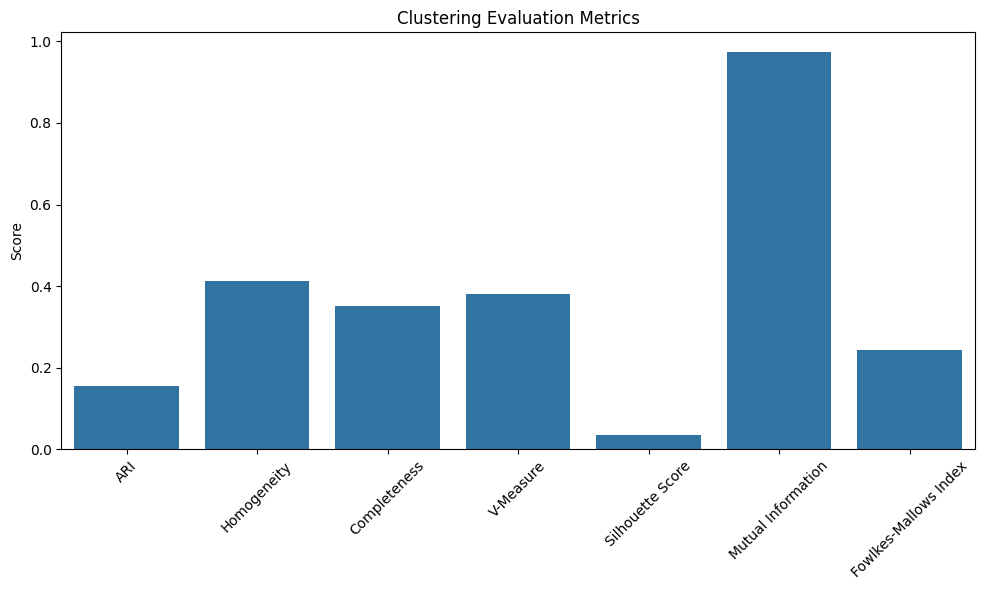

<ipython-input-18-08a2d75275b9>:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




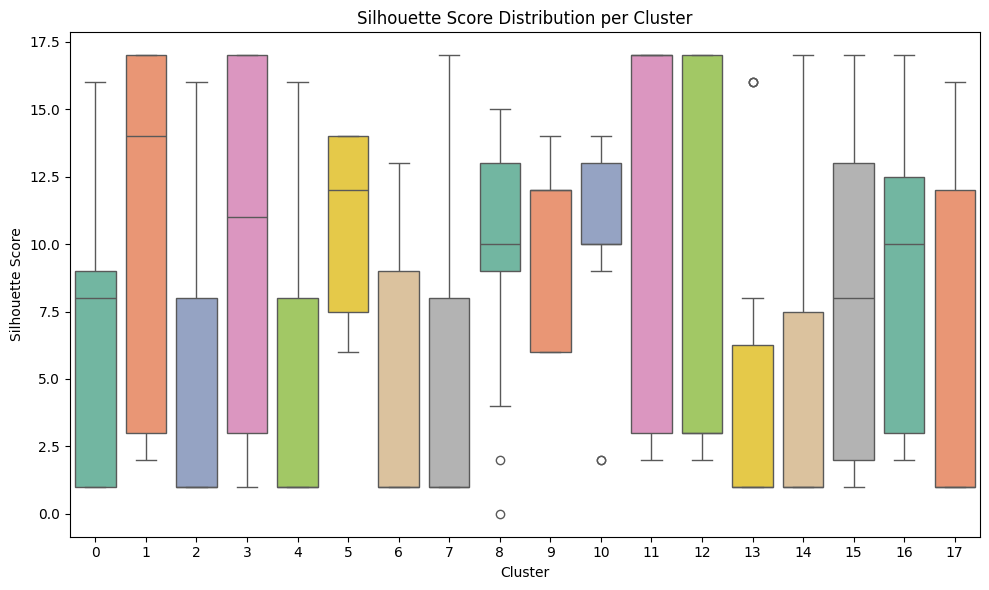

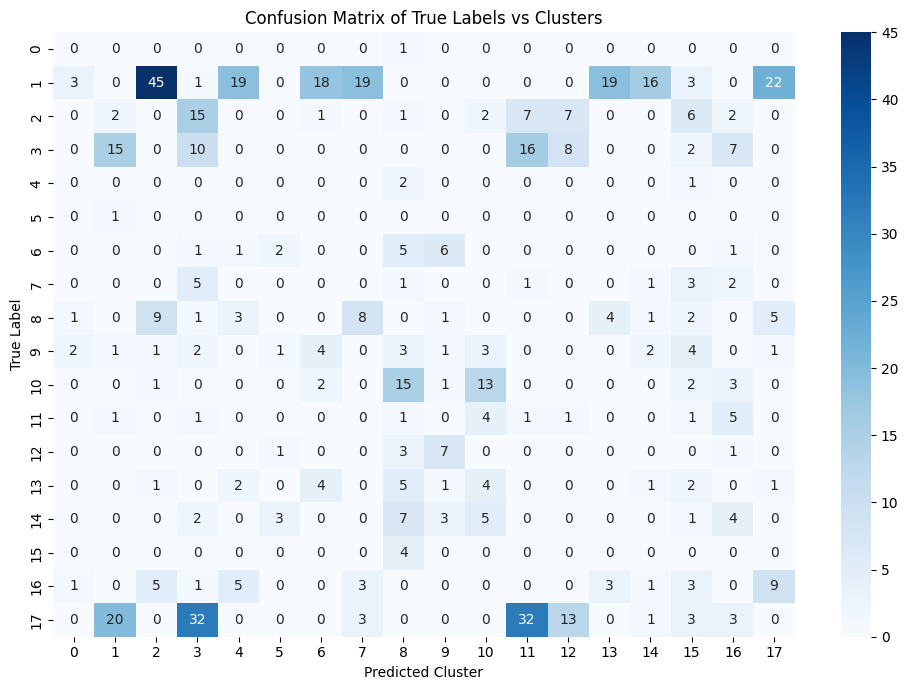

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import umap
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate clustering evaluation metrics
ari_score = adjusted_rand_score(labels, df['cluster'])
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
silhouette_avg = silhouette_score(features, df['cluster'])
mi_score = mutual_info_score(labels, df['cluster'])
fmi_score = fowlkes_mallows_score(labels, df['cluster'])

# Print the evaluation metrics
print(f"Adjusted Rand Index (ARI) score: {ari_score}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Mutual Information: {mi_score}")
print(f"Fowlkes-Mallows Index: {fmi_score}")

# Create a dictionary for the metrics
metrics = {
    'ARI': ari_score,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure,
    'Silhouette Score': silhouette_avg,
    'Mutual Information': mi_score,
    'Fowlkes-Mallows Index': fmi_score
}

# Create a bar plot for the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title("Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For a more detailed look at the Silhouette Score, you can use a boxplot
# If you want to visualize the distribution of the silhouette score across the samples:
silhouette_vals = silhouette_score(features, df['cluster'], sample_size=len(df), metric='euclidean')
plt.figure(figsize=(10, 6))
sns.boxplot(y=labels, x=df['cluster'], palette='Set2')
plt.title("Silhouette Score Distribution per Cluster")
plt.ylabel("Silhouette Score")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# Optional: Create a heatmap for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, df['cluster'])

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix of True Labels vs Clusters")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import confusion_matrix

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply GMM clustering with 18 components (clusters)
gmm = GaussianMixture(n_components=18, random_state=42)
df['cluster'] = gmm.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate clustering evaluation metrics
ari_score = adjusted_rand_score(labels, df['cluster'])
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
silhouette_avg = silhouette_score(features, df['cluster'])
mi_score = mutual_info_score(labels, df['cluster'])
fmi_score = fowlkes_mallows_score(labels, df['cluster'])

# Print the evaluation metrics
print(f"Adjusted Rand Index (ARI) score: {ari_score}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Mutual Information: {mi_score}")
print(f"Fowlkes-Mallows Index: {fmi_score}")

# Create a dictionary for the metrics
metrics = {
    'ARI': ari_score,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure,
    'Silhouette Score': silhouette_avg,
    'Mutual Information': mi_score,
    'Fowlkes-Mallows Index': fmi_score
}

# Create a bar plot for the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title("Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For a more detailed look at the Silhouette Score, you can use a boxplot
# If you want to visualize the distribution of the silhouette score across the samples:
silhouette_vals = silhouette_score(features, df['cluster'], sample_size=len(df), metric='euclidean')
plt.figure(figsize=(10, 6))
sns.boxplot(y=labels, x=df['cluster'], palette='Set2')
plt.title("Silhouette Score Distribution per Cluster")
plt.ylabel("Silhouette Score")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# Optional: Create a heatmap for the confusion matrix
# Compute confusion matrix
conf_matrix = confusion_matrix(labels, df['cluster'])

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix of True Labels vs Clusters")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


Train on clustering instead of classification

# VGG Edited alpha=1

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# def load_model_from_checkpoint(model, checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     return model

# Custom dataset class for chromatin images
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))
        self.transparency = transparency
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))
        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))
        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0
        mask_alpha = (mask_image == 0) * self.transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]
            mask_data = mask_data[:, :, :self.target_size[2]]

        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)

        target = self.cell_type_to_idx[cell_type]
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):
            raw_slice = raw_data[:, :, i].numpy().squeeze()
            mask_slice = mask_data[:, :, i].numpy().squeeze()
            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))
            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)

        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)
        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)

def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)
            inputs = inputs.squeeze(2)
            targets = targets.to(device)
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()
            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load model from checkpoint
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
checkpoint_path = 'fine_tuned_vgg3d_edited.pth'
model = load_model_from_checkpoint(model, checkpoint_path)
model.to(device)

# Extract features and save them to CSV
output_csv = "fine_tuned_vgg3d_edited.csv"
extract_features_and_save(model, dataloader, output_csv)


fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-2-c5b4873f91cb>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Features saved to fine_tuned_vgg3d_edited.csv


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('/content/fine_tuned_vgg3d_edited.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Adjusted Rand Index (ARI) score: 0.035158135454145825


Adjusted Rand Index (ARI) score: 0.035158135454145825


Train on clustering instead of classification

# VGG Edited alpha=1

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# def load_model_from_checkpoint(model, checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     return model

# Custom dataset class for chromatin images
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=0.8):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))
        self.transparency = transparency
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))
        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))
        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0
        mask_alpha = (mask_image == 0) * self.transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]
            mask_data = mask_data[:, :, :self.target_size[2]]

        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)

        target = self.cell_type_to_idx[cell_type]
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):
            raw_slice = raw_data[:, :, i].numpy().squeeze()
            mask_slice = mask_data[:, :, i].numpy().squeeze()
            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))
            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)

        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)
        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)

def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)
            inputs = inputs.squeeze(2)
            targets = targets.to(device)
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()
            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load model from checkpoint
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
checkpoint_path = '/content/fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, checkpoint_path)
model.to(device)

# Extract features and save them to CSV
output_csv = "fine_tuned_vgg3d_edited.csv"
extract_features_and_save(model, dataloader, output_csv)
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('/content/fine_tuned_vgg3d_edited.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-4-27106887b8ad>:32: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to fine_tuned_vgg3d_edited.csv


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('/content/fine_tuned_vgg3d_edited.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.11822039922515458


Adjusted Rand Index (ARI) score: 0.11822039922515458


# Train with Clustering

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
import umap
from sklearn.metrics import adjusted_rand_score

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Custom dataset class for chromatin images
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))
        self.transparency = transparency
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))
        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))
        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0
        mask_alpha = (mask_image == 0) * self.transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]
            mask_data = mask_data[:, :, :self.target_size[2]]

        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)

        target = self.cell_type_to_idx[cell_type]
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):
            raw_slice = raw_data[:, :, i].numpy().squeeze()
            mask_slice = mask_data[:, :, i].numpy().squeeze()
            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))
            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)

        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)
        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

# Define necessary functions and model here (the same as in the original code)...
# I assume Vgg3D, ChromatinDataset, and the other helper functions are already defined in your script.

# Feature extraction function (same as before)
def extract_features_and_save(model, dataloader):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)
            inputs = inputs.squeeze(2)
            targets = targets.to(device)
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()
            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return features_array, labels_array

# Load the dataset
dataset = ChromatinDataset(root_dir='/content/chromatin_task')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
checkpoint_path = '/content/trainingfine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, checkpoint_path)
model.to(device)

# Extract features from the dataset
features, true_labels = extract_features_and_save(model, dataloader)

# Apply KMeans clustering to the features
num_clusters = 18  # Set the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Now treat these cluster labels as pseudo-labels
pseudo_labels = cluster_labels

# Train a new model using the pseudo-labels
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Define the model and optimizer for training
classifier = SimpleClassifier(input_size=features.shape[1], output_size=num_clusters)
classifier.to(device)

criterion = nn.CrossEntropyLoss()  # Since we treat it as a classification task
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Convert the pseudo labels to tensor
pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long).to(device)

# Train the classifier based on the pseudo-labels
def train_classifier(model, features, pseudo_labels, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, pseudo_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Train the model
features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
train_classifier(classifier, features_tensor, pseudo_labels_tensor, optimizer, criterion, epochs=10)

# Evaluate the classifier
def evaluate_classifier(model, features, pseudo_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == pseudo_labels).sum().item()
        accuracy = 100 * correct / len(pseudo_labels)
        print(f"Accuracy: {accuracy:.2f}%")

# Evaluate the classifier on the pseudo-labels
evaluate_classifier(classifier, features_tensor, pseudo_labels_tensor)


fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-6-c78e8cb272d0>:35: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Epoch [1/10], Loss: 2.8932
Epoch [2/10], Loss: 2.8577
Epoch [3/10], Loss: 2.8524
Epoch [4/10], Loss: 2.7919
Epoch [5/10], Loss: 2.7842
Epoch [6/10], Loss: 2.7428
Epoch [7/10], Loss: 2.7175
Epoch [8/10], Loss: 2.6833
Epoch [9/10], Loss: 2.6676
Epoch [10/10], Loss: 2.6426
Accuracy: 42.81%


# Vit

In [ ]:
!pip install open_clip_torch


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import TimesformerForVideoClassification, TimesformerConfig, AutoImageProcessor
from tqdm import tqdm

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors
        raw_data = torch.tensor(raw_data, dtype=torch.float32)
        mask_data = torch.tensor(mask_data, dtype=torch.float32)

        # Get the integer index for the cell_type
        target = self.cell_type_to_idx[cell_type]

        sample_data = {'cell_type': cell_type, 'sample': sample, 'raw': raw_data, 'mask': mask_data, 'target': target}

        if self.transform:
            sample_data['raw'] = self.transform(sample_data['raw'])
            sample_data['mask'] = self.transform(sample_data['mask'])

        return sample_data

# Transformations for augmenting data (if needed)
augmentation_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
])

# Instantiate the dataset
dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=augmentation_transforms)

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

output_classes = len(dataset.cell_types)
# Load pretrained TimeSformer model and processor
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=output_classes,
    ignore_mismatched_sizes=True  # Ignore mismatched sizes for the classifier layer
)

# Modify the final classifier to match the number of classes in your dataset
model.classifier = torch.nn.Linear(model.config.hidden_size, output_classes)

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Function to convert grayscale to RGB
def grayscale_to_rgb(video_clips):
    # Repeat the grayscale channel 3 times to mimic RGB
    return np.repeat(video_clips[..., np.newaxis], 3, axis=-1)

num_epochs = 10

def preprocess_video_frames(video_clips):
    # Ensure that video_clips is a numpy array with shape (batch_size, num_frames, height, width, depth, channels)
    video_clips = np.array(video_clips)  # Convert to numpy array if it's not already
    print(f"Initial video_clips shape: {video_clips.shape}")

    # If the input has an unnecessary dimension, remove it (e.g., 1 in (batch_size, 1, num_frames, height, width, 3))
    if video_clips.shape[1] == 1:
        video_clips = np.squeeze(video_clips, axis=1)  # Remove the redundant singleton dimension
        print(f"After squeezing redundant dimension: {video_clips.shape}")

    # If the input is grayscale (depth = 1), convert it to RGB by repeating the channel
    if video_clips.shape[-1] != 3:
        video_clips = np.repeat(video_clips[..., np.newaxis], 3, axis=-1)
        print(f"Converted video_clips shape (grayscale to RGB): {video_clips.shape}")

    # Ensure the shape is (batch_size, num_frames, height, width, 3)
    if len(video_clips.shape) == 5:  # (batch_size, num_frames, height, width, 3)
        video_clips = video_clips.astype(np.uint8)  # Convert to uint8 for PIL compatibility
        print(f"Processed video_clips shape: {video_clips.shape}")

    return video_clips

# Inside the training loop:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()

        # Prepare video clips and labels
        video_clips = batch['raw']
        labels = batch['target']

        print(f"Raw video_clips shape: {video_clips.shape}")

        # Convert grayscale to RGB and preprocess
        video_clips = preprocess_video_frames(video_clips.numpy())
        print(f"Processed video_clips shape: {video_clips.shape}")

        # Process input and forward pass
        inputs = image_processor(list(video_clips), return_tensors="pt")
        print(f"Inputs shape after image processor: {inputs['pixel_values'].shape}")

        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss and update model
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

model.eval()
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        video_clips = batch['raw']
        labels = batch['target']

        # Convert grayscale to RGB
        video_clips = grayscale_to_rgb(video_clips.numpy())

        # Process input and forward pass
        inputs = image_processor(list(video_clips), return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([18, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([18]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-55-4f348342602b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),  # Adds a channel dimension
Epoch 1/10:   0%|          | 0/16 [00:03<?, ?it/s]

Raw video_clips shape: torch.Size([32, 1, 75, 75, 75])
Initial video_clips shape: (32, 1, 75, 75, 75)
After squeezing redundant dimension: (32, 75, 75, 75)
Converted video_clips shape (grayscale to RGB): (32, 75, 75, 75, 3)
Processed video_clips shape: (32, 75, 75, 75, 3)
Processed video_clips shape: (32, 75, 75, 75, 3)


TypeError: Cannot handle this data type: (1, 1, 75, 3), |u1